In [9]:
%matplotlib inline

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import glob
import multiprocessing as MP
import numpy as np

In [11]:
sns.set_style('ticks')
sns.set_palette('husl')

# Loading data

In [12]:
%%time
# data_files = glob.glob('../data/stats_2019????.csv')
data_files = (
    glob.glob('../data/spaced-algorithms/*.csv')
)

CPU times: user 3.83 ms, sys: 0 ns, total: 3.83 ms
Wall time: 5.74 ms


In [13]:
print('There are {} files.'.format(len(data_files)))

There are 208 files.


In [15]:
%%time

# Specifying the format is ~ 10x faster.
swift_datetime_format = '%a %b %d %Y %H:%M:%S GMT+0000 (%Z)'

def _worker_read_csv(filename):
    df_tmp = pd.read_csv(filename)
    df_tmp.datecreated = pd.to_datetime(df_tmp.datecreated, 
                                        format=swift_datetime_format)
    df_tmp.dateinstallation = pd.to_datetime(df_tmp.dateinstallation, 
                                             format=swift_datetime_format)
    return df_tmp

with MP.Pool() as pool:
    df = pd.concat(pool.map(_worker_read_csv, data_files))

# df = pd.concat([pd.read_csv(f) for f in data_files])
# df.datecreated = pd.to_datetime(df.datecreated)
# df.dateinstallation = pd.to_datetime(df.dateinstallation)

CPU times: user 9.8 s, sys: 6.78 s, total: 16.6 s
Wall time: 1min 24s


# Basic stats

In [16]:
print('Number of unique question: ', df.question.nunique())

Number of unique question:  1917


In [17]:
# Algorithms used
df.algorithm.value_counts()

smart              9953900
random             3487883
spaced             3309270
smartdifficulty      11714
Name: algorithm, dtype: int64

In [18]:
df.user.nunique()

50698

In [19]:
print('Number of unique (category, question): ',
      (df.category.astype(str) + ":" + df.question).nunique())

Number of unique (category, question):  8842


In [20]:
print('Number of unique (set, question): ',
      (df.set + ":" + df.question).nunique())

Number of unique (set, question):  19352


Most questions are answered correctly:

In [22]:
df.correct.value_counts()

1    12475145
0     4287622
Name: correct, dtype: int64

In [23]:
print('{:.2f}% of answers are correct.'
      .format(100 * (df.correct == 1).sum() / df.correct.shape[0]))

74.42% of answers are correct.


In [24]:
algo_group = df.groupby('algorithm')
algo_group.correct.sum() / algo_group.size()

algorithm
random             0.741066
smart              0.747723
smartdifficulty    0.771470
spaced             0.736900
dtype: float64

In [25]:
question_correct_df = df.groupby('question').correct.value_counts().unstack().fillna(0)
question_correct_df['total'] = question_correct_df[0] + question_correct_df[1]
question_correct_df['correct_rate'] = question_correct_df[1] / question_correct_df['total']

In [26]:
question_difficulty = df.groupby('question').difficulty.first()

In [27]:
question_correct_df['difficulty'] = question_difficulty[question_correct_df.index]

In [28]:
for ii in [0, 10, 25, 50, 75, 100]:  # Newer
    idx = question_correct_df.total >= ii
    crr = pearsonr(question_correct_df.correct_rate[idx], question_correct_df.difficulty[idx])
    print('Most frequent - {}/{}, correlation = {:0.2f}'
          .format(idx.sum(), idx.shape[0], crr[0]))

Most frequent - 1917/1917, correlation = 0.46
Most frequent - 1814/1917, correlation = 0.53
Most frequent - 1751/1917, correlation = 0.56
Most frequent - 1638/1917, correlation = 0.59
Most frequent - 1546/1917, correlation = 0.61
Most frequent - 1435/1917, correlation = 0.63


# Transferring to HLR format

In [29]:
def limit_duration(days, alpha, attempts_exact=None):
def limit_duration(days, alpha, attempts_exact=None):
    secs = days * 24 * 60 * 60
    lim = attempt_duration[(secs * (1 - alpha) < attempt_duration.timestamp) & (attempt_duration.timestamp < secs * (1 + alpha))]
    if attempts_exact is not None:
        lim = lim[lim.attempts == attempts_exact]
    
    lim = lim.reset_index()
    valid_tuples = set((lim.lexeme_id + '/' + lim.user_id).values)
    df_dur = df2[(df2.lexeme_id + '/' + df2.user_id).isin(valid_tuples)]
    return df_dur

%%time
multi_algo_users = df.groupby('user').algorithm.nunique()
ignore_users = set(multi_algo_users[multi_algo_users > 1].reset_index().user.tolist())

CPU times: user 15.7 s, sys: 392 ms, total: 16.1 s
Wall time: 16 s


In [30]:
import numpy as np

In [31]:
%%time
df2 = (
    df[~df.user.isin(ignore_users)]
    .rename(columns={
        'correct': 'p_recall', 
        'datecreated': 'timestamp',
        'user': 'user_id',
        'question': 'lexeme_id',
        'count': 'history_seen',
        'language': 'learning_language'
    })
)
# # TODO: This does not sanity check, or else countsequence != correct - wrong
# This was shown to be incorrect.
# df2['history_correct'] = (df2['countsequence'] + df2['history_seen']) / 2
df2['ui_language'] = 'de'
df2['lexeme_string'] = df2['lexeme_id']
df2['session_seen'] = 1
df2['session_correct'] = df2['p_recall']
df2['timestamp'] = df2['timestamp'].values.astype(np.int64) // 10 ** 9
df2.sort_values(by=['user_id', 'lexeme_id', 'timestamp'], inplace=True)

CPU times: user 18.6 s, sys: 6.33 s, total: 24.9 s
Wall time: 24.8 s


In [32]:
%%time
df2['delta'] = df2['timestamp'].diff()

CPU times: user 53.6 ms, sys: 64.3 ms, total: 118 ms
Wall time: 116 ms


In [33]:
%%time
df2.loc[(df2.lexeme_id != df2.lexeme_id.shift()) | (df2.user_id != df2.user_id.shift()), 'delta'] = None

CPU times: user 2.38 s, sys: 293 ms, total: 2.67 s
Wall time: 2.65 s


In [34]:
%%time
history_correct = df2.p_recall.cumsum()
history_correct_correction = history_correct.copy()
history_correct_correction[:] = np.nan
history_correct_correction[df2.delta.isnull()] = history_correct[df2.delta.isnull()] - df2.p_recall[df2.delta.isnull()]
history_correct -= history_correct_correction.fillna(method='ffill')

CPU times: user 14.8 s, sys: 17 s, total: 31.8 s
Wall time: 31.8 s


In [35]:
df2['history_correct'] = history_correct

In [36]:
df_grouped = df2.groupby(['user_id', 'lexeme_id']).timestamp.size()

In [37]:
assert df2.delta.isnull().sum() == df_grouped.shape[0], "Number of user_id, lexeme_id mismatch."

In [38]:
%%time
min_count = 1
df_filtered = df_grouped[df_grouped >= min_count]
idx_filtered = sorted({x[0] + '/' + x[1] for x in df_filtered.reset_index()[['user_id', 'lexeme_id']].values})
df_user_lexeme = (df2.user_id + '/' + df2.lexeme_id).values.tolist()

select_idx = [False] * len(df_user_lexeme)
i, j = 0, 0
while i < len(df_user_lexeme) and j < len(idx_filtered):
    if df_user_lexeme[i] == idx_filtered[j]:
        select_idx[i] = True
        i += 1
    elif df_user_lexeme[i] < idx_filtered[j]:
        i += 1
    elif df_user_lexeme[i] > idx_filtered[j]:
        j += 1

CPU times: user 21.5 s, sys: 1.94 s, total: 23.4 s
Wall time: 23.4 s


## Empirical forgetting rate

In [39]:
%%time
duration_grp = df2.groupby(['lexeme_id', 'user_id'])
duration_df = (duration_grp.timestamp.last() - duration_grp.timestamp.first()).to_frame('timestamp')
attempts_df = duration_grp.size().to_frame('attempts')
attempt_duration = duration_df.join(attempts_df)

CPU times: user 15.3 s, sys: 1.45 s, total: 16.7 s
Wall time: 16.7 s


In [40]:
long_term_users = set(duration_df[duration_df.timestamp > 3 * (1 - 0.25) * 86400].reset_index().user_id.unique().tolist())

In [41]:
def limit_duration(days, alpha, attempts_exact=None):
    secs = days * 24 * 60 * 60
    lim = attempt_duration[(secs * (1 - alpha) < attempt_duration.timestamp) & (attempt_duration.timestamp < secs * (1 + alpha))]
    if attempts_exact is not None:
        lim = lim[lim.attempts == attempts_exact]
    
    lim = lim.reset_index()
    valid_tuples = set((lim.lexeme_id + '/' + lim.user_id).values)
    df_dur = df2[(df2.lexeme_id + '/' + df2.user_id).isin(valid_tuples)]
    return df_dur

In [42]:
%%time
lexeme_init_grp = df2.sort_values('timestamp').groupby(['lexeme_id', 'user_id'])
lexeme_initial = lexeme_init_grp.nth(2)
lexeme_first = lexeme_init_grp.nth(1)
lexeme_first_delta = (lexeme_initial.timestamp - lexeme_first.timestamp).dropna().to_frame('t_diff').reset_index()
lexeme_initial = lexeme_initial.reset_index()

lexeme_initial_m = lexeme_initial.groupby('lexeme_id').p_recall.mean()
lexeme_initial['emp_n0'] = -np.log(lexeme_initial_m.loc[lexeme_initial.lexeme_id].values) / (lexeme_first_delta.t_diff.values / (24 * 60 * 60))
lexeme_initial_emp_n0 = lexeme_initial.groupby('lexeme_id').emp_n0.mean()

CPU times: user 32.2 s, sys: 5.07 s, total: 37.3 s
Wall time: 37.2 s


/home/utkarshu/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


In [48]:
%%time
lexeme_user_initial = lexeme_initial.copy()
lexeme_user_initial['user_lexeme'] = lexeme_user_initial['user_id'] + '/' + lexeme_user_initial['lexeme_id']
# (- np.log(max(0.01, min(0.99, first_session['p_recall'] + 1e-10))) / (first_session['delta_scaled'] + 0.1))
lexeme_user_initial['emp_n0'] = (
    - np.log(np.maximum(0.001, np.minimum(0.999, lexeme_user_initial.p_recall.values.squeeze()))) /
    (lexeme_first_delta.t_diff.values / (24 * 60 * 60))
)
lexeme_user_initial = lexeme_user_initial.set_index('user_lexeme')
lexeme_emp_n0 = lexeme_user_initial.groupby('lexeme_id').emp_n0.mean()

CPU times: user 644 ms, sys: 415 ms, total: 1.06 s
Wall time: 1.06 s


In [49]:
from scipy.stats import mannwhitneyu

NORM_BY_INIT_N0 = True
P_MIN, P_MAX = 0.01, 0.99

pm_frac = 0.25

import warnings

def _empirical_n_worker(params):
    days, N = params
    grp = limit_duration(days=days, alpha=pm_frac, attempts_exact=None).sort_values('timestamp').groupby(['lexeme_id', 'user_id'])
    nth = grp.nth(N)
    n_1th = grp.nth(N - 1)
    delta = (nth.timestamp - n_1th.timestamp).dropna().to_frame('t_diff').reset_index()
    nth = nth.reset_index()
    
    lexeme_emp_m = nth.groupby('lexeme_id').p_recall.mean()
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        # (- np.log(max(0.01, min(0.99, first_session['p_recall'] + 1e-10))) / (first_session['delta_scaled'] + 0.1))
        nth['emp_n'] = -np.log(np.maximum(P_MIN, np.minimum(P_MAX, nth['p_recall']))) / (delta.t_diff.values / (24 * 60 * 60))
        if NORM_BY_INIT_N0:
            nth['emp_n'] /= lexeme_emp_n0.loc[nth.lexeme_id].values
        
    ssig = {}
    try:
        for alg1, alg2 in [('smart', 'random'), ('spaced', 'random'), ('spaced', 'smart')]:
            ssig[(alg1, alg2)] = mannwhitneyu(nth.emp_n[nth.algorithm == alg1], nth.emp_n[nth.algorithm == alg2])
            
        desc = (
            nth
            .groupby('algorithm')
            .emp_n
            .describe()
        )
    except Exception:
        desc = None
    
    valid_lexeme_num = nth.lexeme_id.nunique()
    return days, N, valid_lexeme_num, desc, ssig

In [50]:
_empirical_n_worker((4, 3))

(4,
 3,
 1412,
              count      mean        std           min       25%       50%  \
 algorithm                                                                   
 random      6839.0  2.287088  57.625193  4.002687e-07  0.000070  0.001178   
 smart      21861.0  0.793326  12.103820  3.149857e-07  0.000085  0.000881   
 spaced      5673.0  0.987116  22.062186  2.938905e-07  0.000060  0.000386   
 
                 75%          max  
 algorithm                         
 random     0.018865  4022.440163  
 smart      0.014536   888.955036  
 spaced     0.011157  1498.676413  ,
 {('smart',
   'random'): MannwhitneyuResult(statistic=73899881.0, pvalue=0.07667299522108814),
  ('spaced',
   'random'): MannwhitneyuResult(statistic=17761437.0, pvalue=1.9660515259386194e-16),
  ('spaced',
   'smart'): MannwhitneyuResult(statistic=57143055.5, pvalue=3.7167278539229464e-20)})

In [51]:
%%time
lexeme_data_2 = []
P_VALUE = 0.05

with MP.Pool() as pool:
    for days, N, valid_lexeme_num, desc, ssig in pool.map(
        _empirical_n_worker,
        [(days, N) for days in [3, 5, 9] for N in range(3, 9)]
    ):
        if desc is not None:
            lexeme_data_2.append({
                'N': N,
                'days': days,
                'valid_lexeme_num': valid_lexeme_num,
                'smart_random_sig': ssig[('smart', 'random')].pvalue < P_VALUE,
                'spaced_smart_sig': ssig[('spaced', 'smart')].pvalue < P_VALUE,
                'spaced_random_sig': ssig[('spaced', 'random')].pvalue < P_VALUE,
            })
            
            for alg in ['smart', 'random', 'spaced']:
                for field in ['count', '25%', '50%', '75%', 'mean']:
                    lexeme_data_2[-1][f'{alg}_{field}'] = desc[field][alg]

CPU times: user 63.4 ms, sys: 8.27 s, total: 8.34 s
Wall time: 19.1 s


In [55]:
analysis_df_2 = pd.DataFrame(lexeme_data_2)

In [57]:
analysis_df_2

,N,days,random_25%,random_50%,random_75%,random_count,random_mean,smart_25%,smart_50%,smart_75%,...,smart_mean,smart_random_sig,spaced_25%,spaced_50%,spaced_75%,spaced_count,spaced_mean,spaced_random_sig,spaced_smart_sig,valid_lexeme_num
0,3,3,0.000093,0.001543,0.023854,5552.0,2.577312,0.000107,0.001171,0.017670,...,0.883152,False,0.000087,0.000574,0.014922,4027.0,1.084353,True,True,1399
1,4,3,0.000127,0.002279,0.033637,2873.0,5.685223,0.000174,0.002701,0.027223,...,1.103075,False,0.000093,0.000718,0.024262,1854.0,1.787792,True,True,1300
2,5,3,0.000156,0.003294,0.040676,1516.0,11.358232,0.000264,0.003291,0.030462,...,22.678956,False,0.000134,0.001781,0.031117,998.0,4.491595,True,True,1186
3,6,3,0.000299,0.005259,0.034898,892.0,15.896397,0.000327,0.003010,0.028800,...,1.404616,False,0.000227,0.005325,0.047645,579.0,1.125692,False,False,1027
4,7,3,0.000210,0.005077,0.033956,535.0,5.298718,0.000194,0.001790,0.022945,...,1.603833,True,0.000362,0.006338,0.031722,392.0,14.198261,False,True,904
5,8,3,0.000469,0.006638,0.058993,336.0,2.328838,0.000679,0.004328,0.029561,...,1.637817,False,0.000334,0.006924,0.032089,256.0,1.244032,False,False,785
6,3,5,0.000064,0.001046,0.015327,8349.0,2.321260,0.000071,0.000802,0.013387,...,0.797900,False,0.000054,0.000418,0.011836,6232.0,2.463230,True,True,1398
7,4,5,0.000116,0.001339,0.019731,4402.0,14.452003,0.000101,0.001200,0.016647,...,0.955198,True,0.000072,0.000660,0.012875,3455.0,0.791235,True,True,1317
8,5,5,0.000101,0.001855,0.023929,2589.0,3.746675,0.000142,0.001511,0.019726,...,1.259105,False,0.000084,0.000974,0.016564,2210.0,1.010344,True,True,1227
9,6,5,0.000170,0.001987,0.025605,1622.0,9.332499,0.000188,0.002405,0.024929,...,1.702087,False,0.000126,0.001301,0.021900,1278.0,1.186451,True,True,1114


In [59]:
print(f"spaced median empirical forgetting rate is better in {round(analysis_df_2[analysis_df_2['spaced_50%'] < analysis_df_2['smart_50%']].shape[0] / analysis_df_2.shape[0] * 100., 1)}% of the cases.")

spaced median empirical forgetting rate is better in 83.3% of the cases.


In [60]:
analysis_df_2[(analysis_df_2['spaced_50%'] < analysis_df_2['random_50%'])].shape[0] / analysis_df_2.shape[0]

0.8333333333333334

In [61]:
analysis_df_2[(analysis_df_2['spaced_50%'] < analysis_df_2['random_50%']) & analysis_df_2.spaced_random_sig].shape[0] / analysis_df_2.shape[0]

0.7222222222222222

In [62]:
analysis_df_2[analysis_df_2['spaced_50%'] < analysis_df_2['smart_50%']].shape[0] / analysis_df_2.shape[0]

0.8333333333333334

In [63]:
analysis_df_2[(analysis_df_2['spaced_50%'] < analysis_df_2['smart_50%']) & analysis_df_2.spaced_smart_sig].shape[0] / analysis_df_2.shape[0]

0.7777777777777778

In [70]:
# Create figure and axes

def label_diff(algo, X, Y_1, Y_2, W, repetitions, day):
    for i in range(repetitions):
        is_sig = analysis_df_2[(analysis_df_2.days == day)]['spaced_' + algo + '_sig'].values[i]
        y = 1.1 * max(Y_1[i], Y_2[i])

        props = {
            'connectionstyle': 'bar',
            'arrowstyle': '-',
            'shrinkA': 0,
            'shrinkB': 0,
            'linewidth': 0.7,
            'color': 'black'
        }

        if is_sig:
            plt.gca().annotate("*", xy=(X[i] - W / 2 - 0.02, y * 1.2), zorder=10, fontsize=15)
        plt.gca().annotate('', xy=(X[i] - W, y), xytext=(X[i] + 0.25 * W, y), color='k',
                           arrowprops=props)

ALG_LABEL = {
    'spaced': r'select',
    'smart': 'difficulty',
    'random': 'random'
}

def plot_day_perf(day):
    clrs = sns.color_palette('Set2', n_colors=3)
    df_plot = analysis_df_2[(analysis_df_2.days == day)]
    for idx, alg in enumerate(['random', 'spaced', 'smart']):
        yerr = np.vstack([
            df_plot[f'{alg}_50%'] - df_plot[f'{alg}_25%'],
            df_plot[f'{alg}_75%'] - df_plot[f'{alg}_50%']
        ])
        plt.errorbar(
            x=df_plot['N'] - 1 - (idx - 1) * 0.2, 
            y=df_plot[f'{alg}_50%'], 
            yerr=yerr,
            color=clrs[idx],
            label=ALG_LABEL[alg],
            fmt='x',
            elinewidth=12,
            alpha=0.2,
        )
        if alg == 'random':
            label_diff(
                algo=alg, 
                X=(df_plot['N'] - 1 - (idx - 1) * 0.2).values,
                Y_1=df_plot[f'{alg}_75%'].values,
                Y_2=df_plot[f'spaced_75%'].values,
                W = 0.2,
                repetitions=df_plot.shape[0],
                day=day
            )
        elif alg == 'spaced':
             label_diff(
                algo='smart', 
                X=(df_plot['N'] - 1 - (idx - 1) * 0.2).values,
                Y_1=df_plot[f'{alg}_75%'].values,
                Y_2=df_plot[f'smart_75%'].values,
                W = 0.2,
                repetitions=df_plot.shape[0],
                day=day
            )
        plt.scatter(
            df_plot['N'] - 1 - (idx - 1) * 0.2,
            df_plot[f'{alg}_50%'],
            marker='x',
            color=clrs[idx],
            label=None
        )
    plt.yscale('log')
    plt.xlabel('# reviews')
    plt.ylabel('$\hat{n}$' if not NORM_BY_INIT_N0 else r'$\frac{\hat{n}}{\hat{n}_0}$')
    plt.title(f'$T = {day} \\pm {round(pm_frac * day, 1)}$ days')
    plt.legend(loc='lower left')
    sns.despine()
    plt.tight_layout()

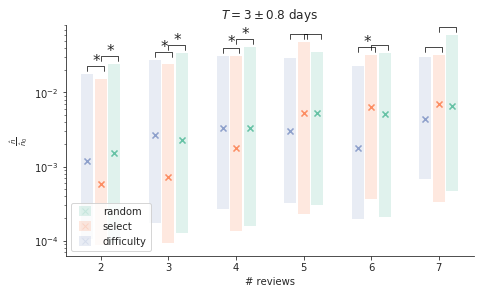

In [71]:
fig = plt.figure(figsize=(2 * 3.39, (np.sqrt(5) - 1) * 3.39))
plot_day_perf(3)

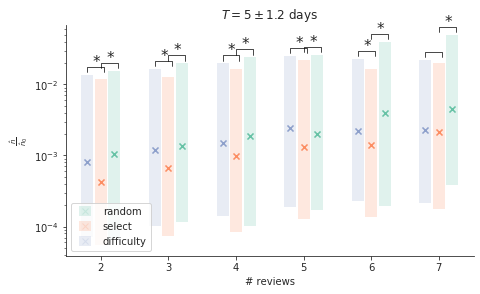

In [72]:
fig = plt.figure(figsize=(2 * 3.39, (np.sqrt(5) - 1) * 3.39))
plot_day_perf(5)

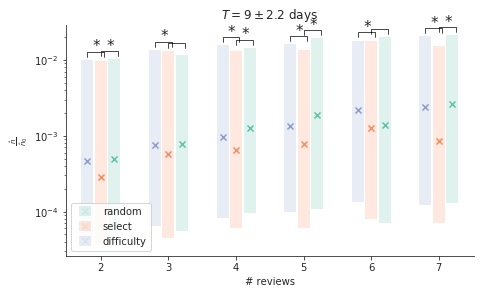

In [73]:
fig = plt.figure(figsize=(2 * 3.39, (np.sqrt(5) - 1) * 3.39))
plot_day_perf(9)